# Práctica 3.2: Clustering

<center><h3>
    Pedro López-Chaves Pérez
</h3></center>

## Instrucións

Isto é un **Jupyter Notebook**, un documento que integra código Python nun arquivo Markdown.
Isto permítenos, ir exexutando celdas de código pouco a pouco, así como xerar automáticamente un informe ben formateado da práctica.

Podes engadir unha celda co botón **"Insert"** da barra de ferramentas, e cambiar seu tipo con **"Cell > Cell Type"**

Para executar unha celda de código, seleccionarémola e pulsaremos a botón **"▶ Run"** da barra de ferramentas.
Para pasar o documento a HTML, seleccionaremos **"File > Download as > HTML (.html)"**

Segue este guión ata o final. Executa o código proporcionado paso a paso comprendendo o que estás a facer e reflexionando sobre os resultados. Haberá preguntas intercaladas ao longo do guión, responde a todas elas na sección reservada para ese fin: **"Respostas ao cuestionario"**. Por favor, non modifiques ningunha liña de código agás cando se che pida explícitamente.

Non esquezas insertar o teu **nome e apelidos** na celda superior.

## Entrega da práctica

A data límite de entrega será a indicada no Campus Virtual. A entrega consistirá nun único arquivo comprimido co nome `APELIDOS_NOME_Clustering.zip` que conteña os seguintes ficheiros:

 * `APELIDOS_NOME_Clustering.html`: Arquivo HTML froito da exportación do presente Notebook, coas preguntas respondidas ao final do documento.
 * `APELIDOS_NOME_Clustering.ipynb`: Arquivo Jupyter Notebook fonte.
 * Arquivo de datos do problema de libre elección.

## Números aleatorios

<span style="color:red">**MOI IMPORTANTE:**</span> Vamos a establecer un *seed* cun valor predefinido inmediatamente antes de executar calquera operación cun compoñente aleatorio. Así nos aseguraremos de que os nosos resultados sexan repetibles.

Isto é, imos poñer `np.random.seed(SEED_VALUE)` antes de:
 - `train_test_split()`
 - `fit()`
 - `predict()`
 
Tamén imos poñer `random_state=SEED_VALUE` en aquelas funcións que o admitan (coma o construtor de `KMeans`).

Haberá ocasión nas que isto sexa excesivo, pero así curámonos en despistes.

# Introdución

Nesta práctica imos reforzar os conceptos vistos nas clases teóricas sobre aprendizaxe non supervisada. Comezaremos traballando sobre un conxunto de datos xa coñecido, o da superficie e prezo das vivendas, sobre o cal aplicaremos o algoritmo **k-means**. O segundo exercicio consistirá en aplicar clustering a un problema de libre elección.

# Clustering sobre o dataset das vivendas

Na práctica anterior fomos capaces de dar un prezo estimado das vivendas a partir da súa superficie. Agora imos usar as dúas variables, superficie e prezo, para buscar novas relacións entre os nosos datos e facer unha distinción en varias categorías de vivendas.

Cargamos os datos empregando a función `read_csv()`:

In [1]:
import pandas as pd  # Importamos a librería (isto sólo é necesario facelo unha vez)

vivendas = pd.read_csv('vivendas.csv',  # Cargamos o csv
                       delimiter=',',
                       header=0)

Nesta práctica non vai ser preciso dividir os datos en dous conxuntos (adestramento e test), xa que o que queremos atopar son **novas** relacións. Isto implica tamén que non vai haber ningunha etapa de validación de modelos. En lugar diso, o que se adoita facer é unha etapa de análise e interpretación dos agrupamentos obtidos.

## Agrupamento empregando funcións propias

___K-means___ é un algoritmo de clasificación non supervisada (*clustering*) que agrupa os exemplos dun conxunto de datos en $k$ grupos baseándose nas súas características. O agrupamento realízase minimizando a suma de distancias (habitualmente distancia cadrática) entre cada exemplo e o centroide do grupo (*cluster*) ao que foi asignado. 

O algoritmo consta de 3 etapas diferenciadas:

1. **Inicialización**: unha vez escollido o número de grupos $k$, establécense aleatoriamente $k$ centroides no espazo de datos.
2. **Asignación dos exemplos aos centroides**: cada instancia do dataset é asignada ao seu centroide máis próximo.
3. **Actualización dos centroides**: para cada grupo, actualízase a posición do centroide tomando como novo centroide a posición media dos exemplos pertenecentes a dito grupo.
 
Os pasos 2 e 3 repítense durante $n$ iteracións. O algoritmo resolve un problema de optimización, sendo a función a optimizar (minimizar) a suma das distancias cadráticas de cada exemplo ao centroide do seu cluster.
 
Imos empregar as seguintes funcións:

In [2]:
import numpy as np

# Función de distancia cadrática
def calcula_distancias(a, b):
    matriz_distancias = np.empty([a.shape[0], b.shape[0]])
    # Calculamos a distancia punto a punto dos conxuntos a e b
    for i in range(a.shape[0]):
        for j in range(b.shape[0]):
            dist = a[i] - b[j]
            matriz_distancias[i, j] = dist[0] ** 2 + dist[1] ** 2
    
    return matriz_distancias

# Función a optimizar J
def j(x, centroides, clusters):
    # Obtemos a distancia de cada punto ao seu cluster
    distancias = x - centroides[clusters]
    # Calculamos o custo
    custo = 1.0/x.shape[0] * sum((np.sqrt(distancias[:, 0]**2 + distancias[:,1]**2))**2)
    return custo

# Función de actualización de centroides
def actualiza_centr(x, clusters, centroides):
    for i in range(centroides.shape[0]):
        x_cluster_i = x[clusters==i]
        centroides[i] = np.sum(x_cluster_i, axis=0)/x_cluster_i.shape[0]
    
    return centroides

# Función de clustering k-means
def k_medias(x, centroides, iteracions):
    hist_clusters = []
    hist_centroides = []
    hist_custo = []
    
    for i in range(iteracions):
        dist_centroides = calcula_distancias(x, centroides)
        clusters = np.argmin(dist_centroides, axis=1)
        centroides = actualiza_centr(x, clusters, centroides)
        custo = j(x, centroides, clusters)
        # Gardamos o historial de cada iteración
        hist_clusters.append(clusters)
        hist_centroides.append(centroides.copy())
        hist_custo.append(custo)
    
    return {'custo': hist_custo, 'clusters': hist_clusters, 'centroides': hist_centroides}

Xa podemos realizar un primeiro agrupamento. Convertemos o dataset a unha matriz porque neste caso facilítanos as operacións:

In [3]:
vivendas_mat = vivendas.values

Tomamos 3 exemplos ao azar como centroides iniciais (non debemos esquecernos de definir unha semente para que os resultados sexan reptibles):

In [4]:
SEED_VALUE = 190463  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados

np.random.seed(SEED_VALUE)
centr_iniciais = vivendas_mat[np.random.choice(vivendas_mat.shape[0], size=3, replace=False)]
centr_iniciais

array([[210.  , 299.9 ],
       [106.  , 104.96],
       [ 76.  ,  80.15]])

Invocamos o método `k_medias`:

In [5]:
# Definimos o número de iteracións do algoritmo
n_iter = 20
# Invocamos o método k_medias
agrupamento_1 = k_medias(vivendas_mat, centr_iniciais, n_iter)

A variable `agrupamento_1` almacena o historial de custos, os centroides e as asignacións de cada exemplo aos 3 clusters en todas as iteracións. Aquí tes algúns exemplos da información á que podes acceder:

In [7]:
# Custo trala primeira iteración
agrupamento_1['custo'][0]

3649.4144836282358

In [8]:
# Custo final
agrupamento_1['custo'][n_iter-1]

2072.6093651192277

In [9]:
# Centroides na iteración 4
agrupamento_1['centroides'][3]

array([[208.57142857, 351.38357143],
       [126.61538462, 157.60307692],
       [ 93.87878788,  86.56242424]])

In [10]:
# Asignación dos 6 primeiros exemplos do dataset aos clusters na última iteración
agrupamento_1['clusters'][n_iter-1][:6]

array([2, 1, 1, 2, 1, 2])

Imos graficar paso a paso como foi converxendo o algoritmo para chegar ao agrupamento definitivo:

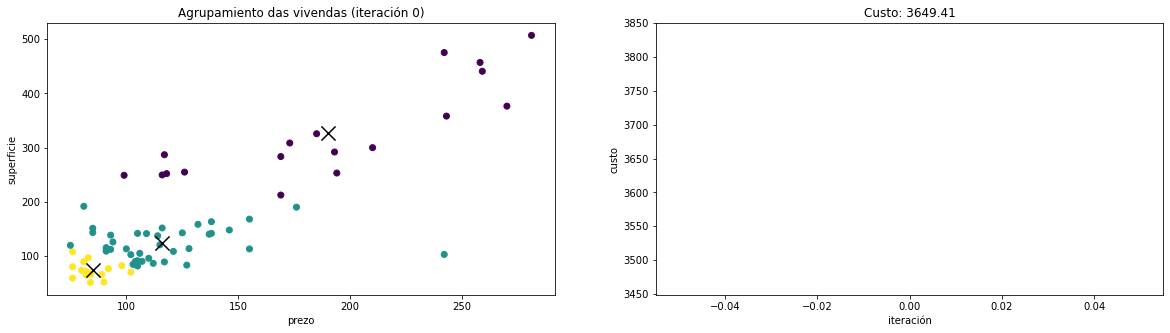

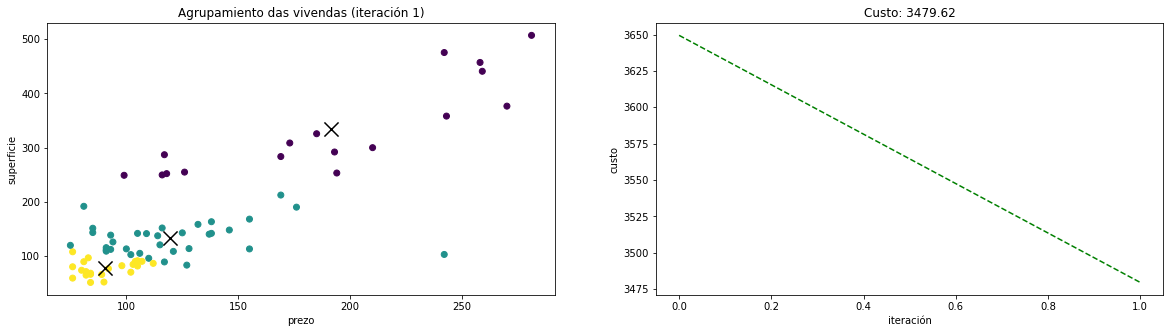

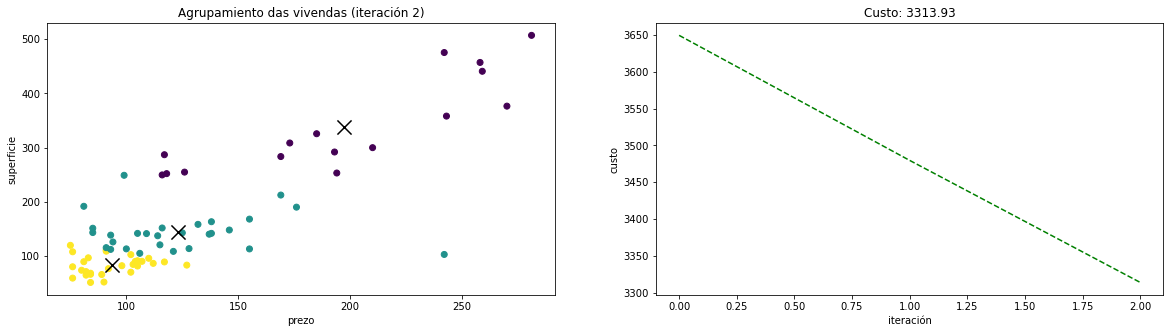

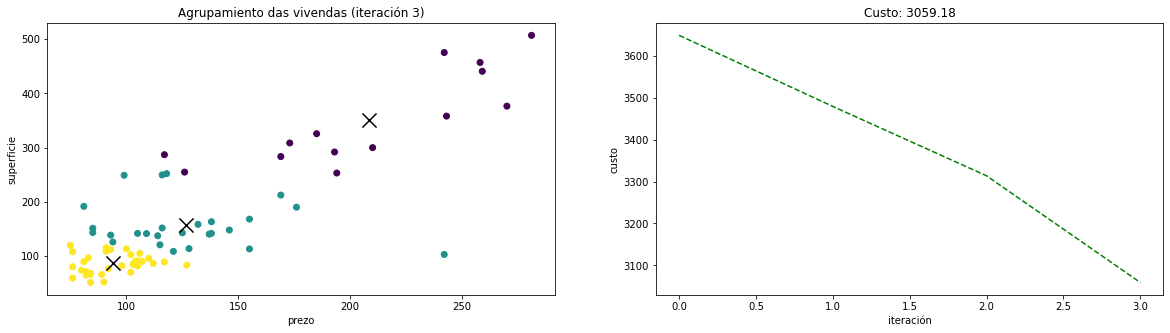

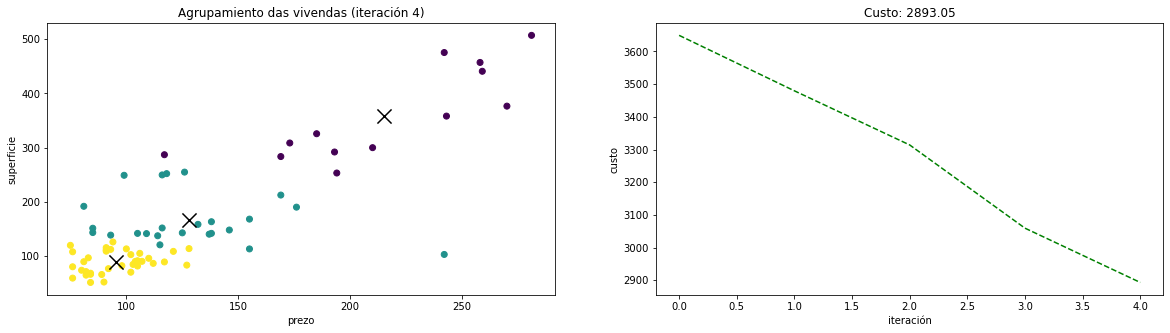

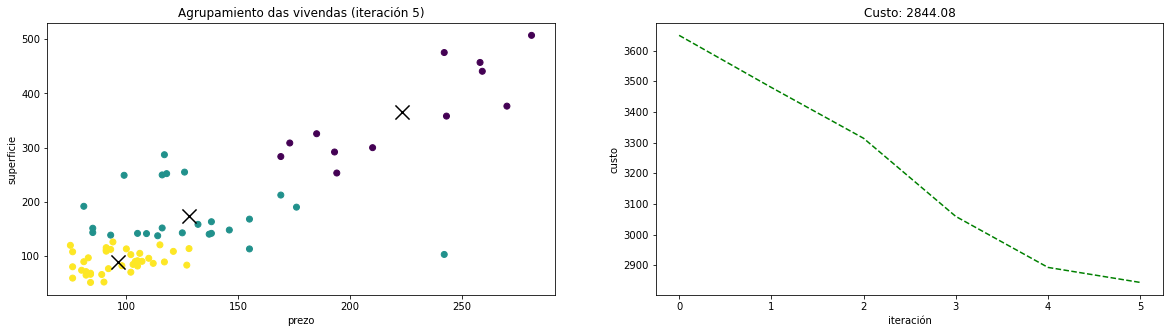

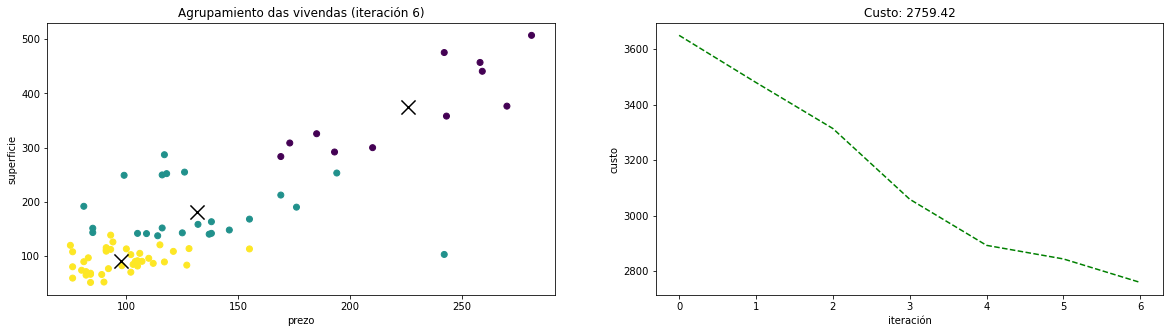

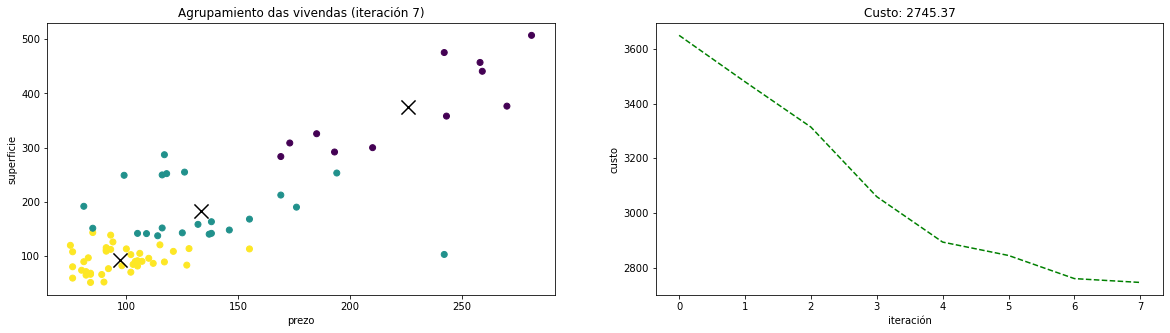

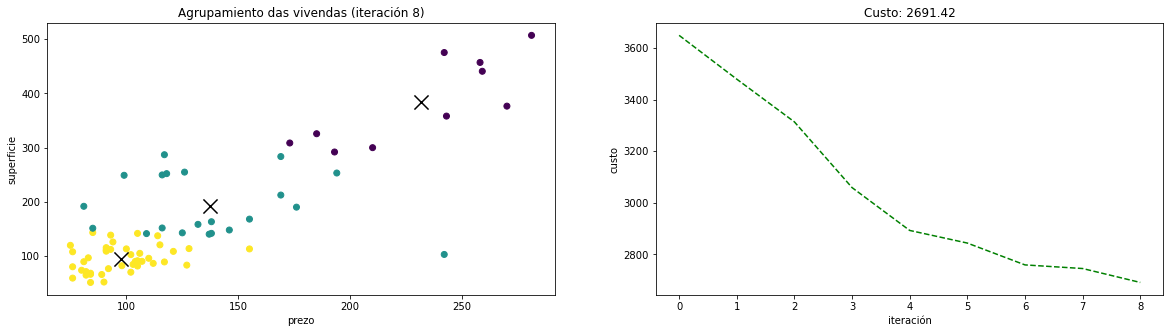

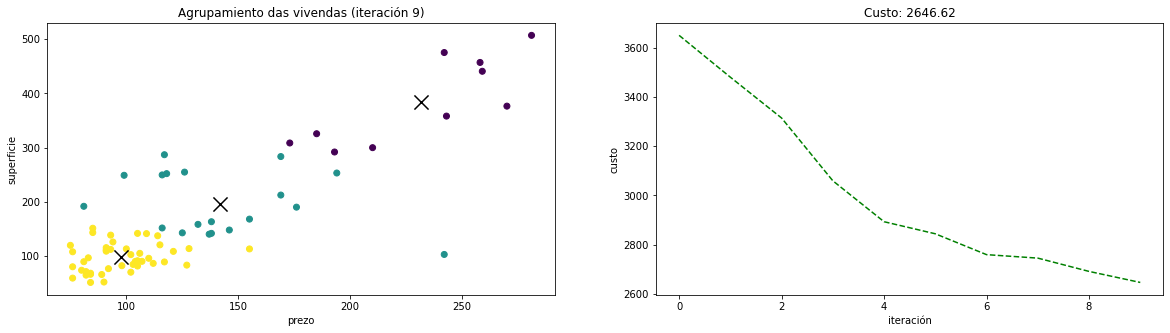

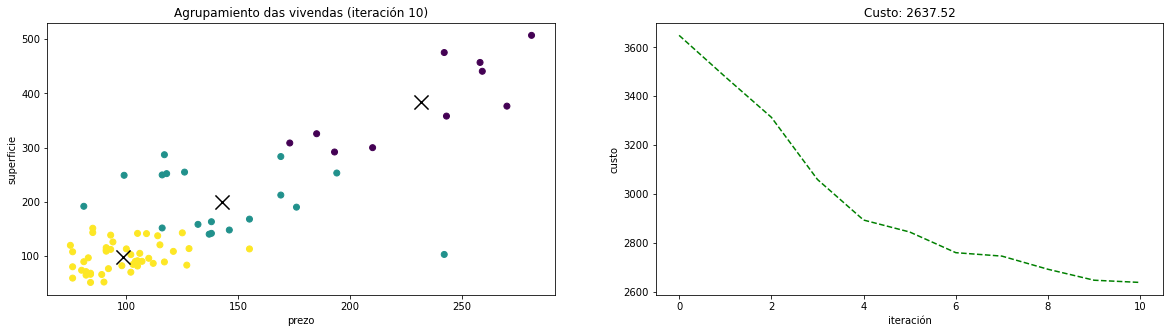

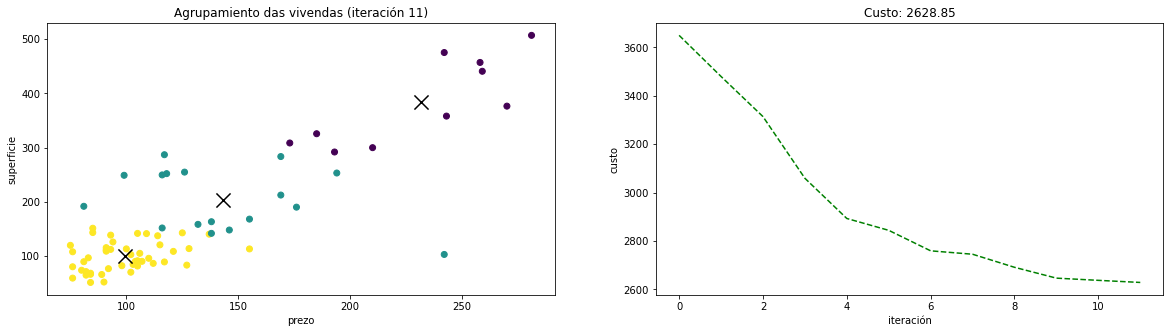

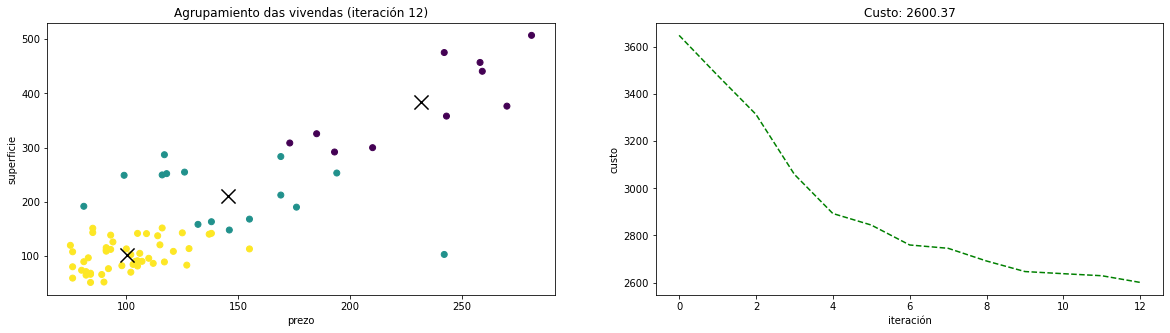

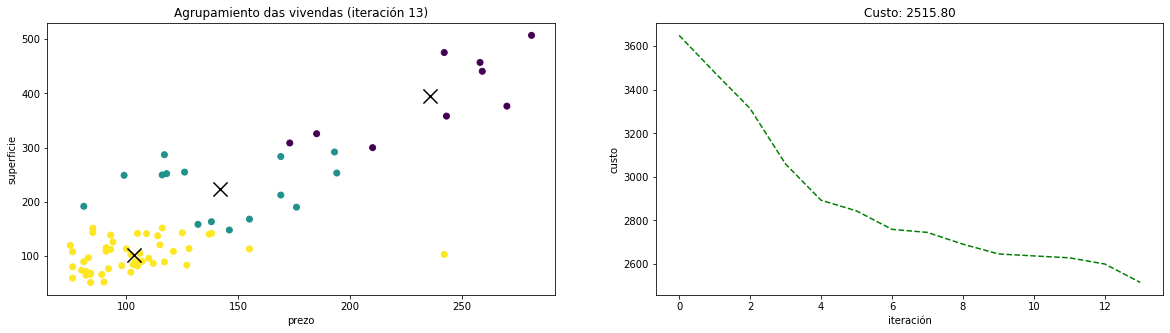

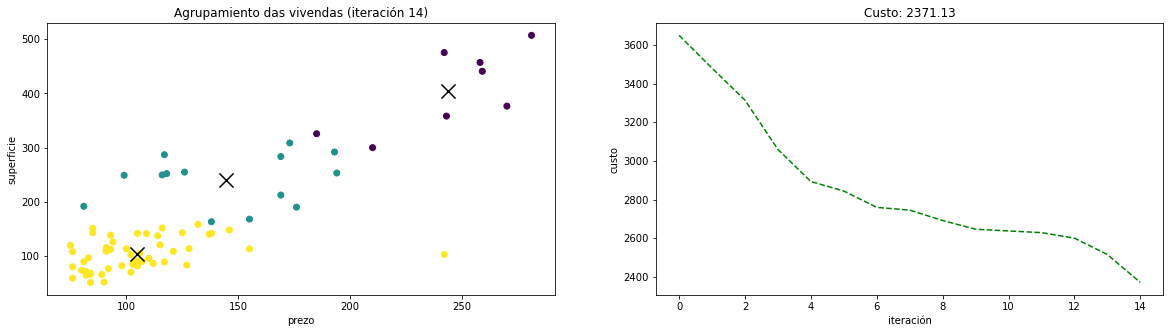

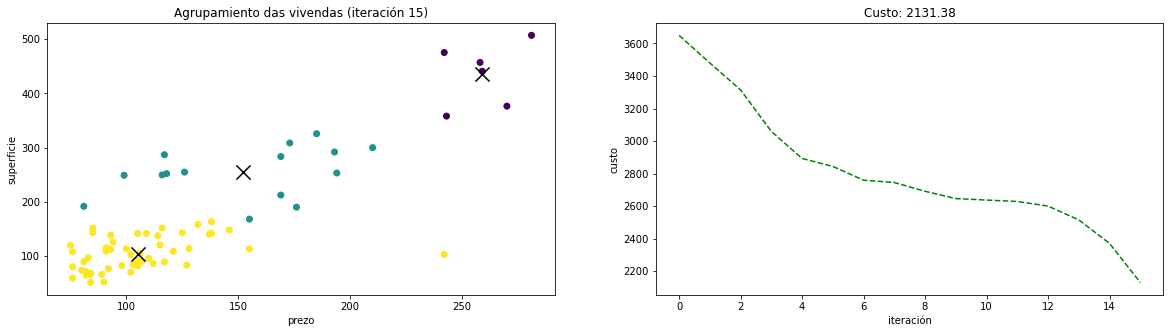

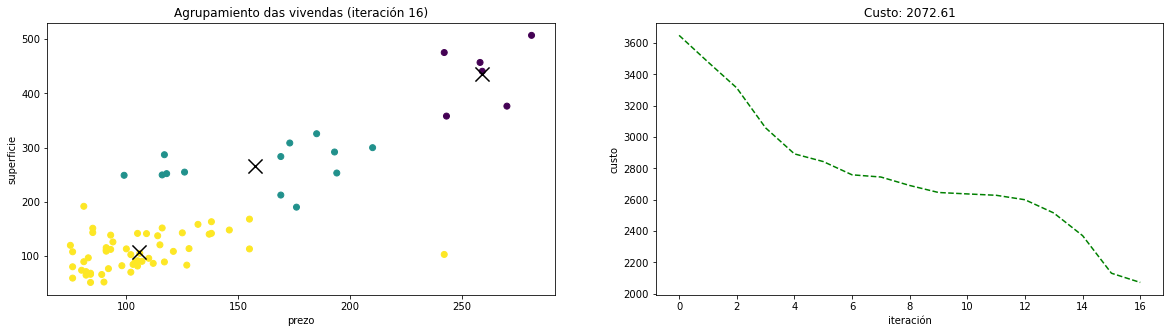

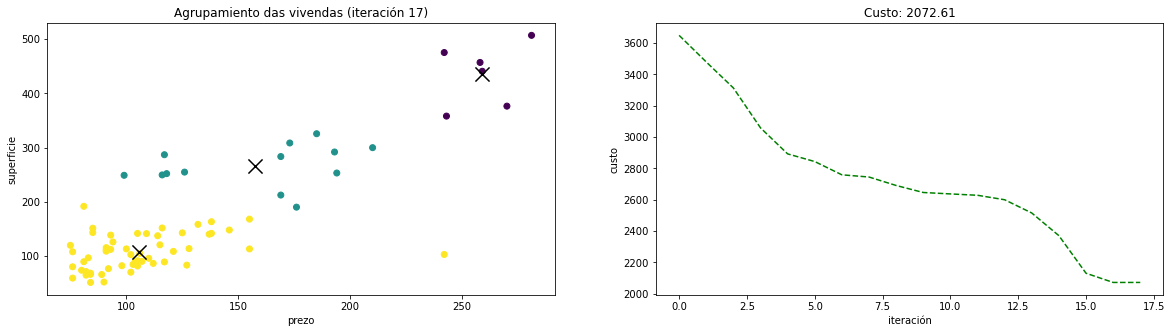

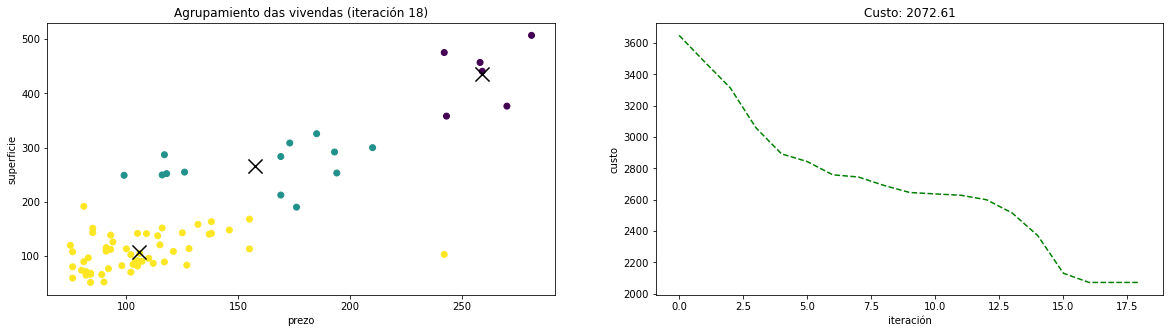

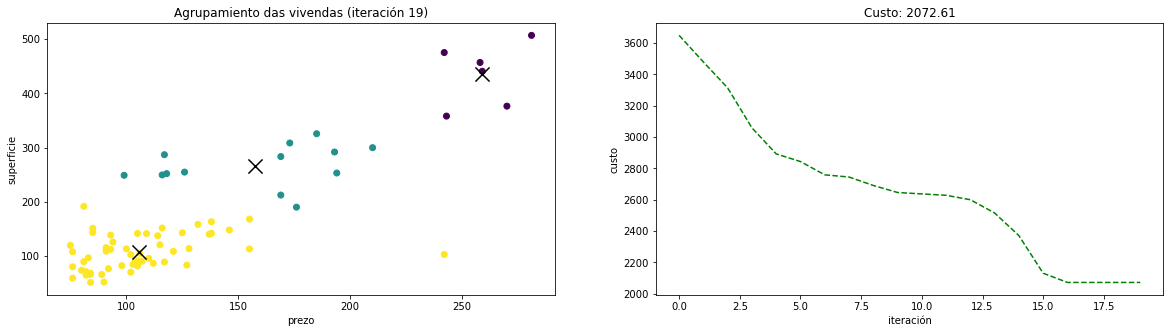

In [11]:
import matplotlib.pyplot as plt

for i in range(n_iter):
    fig = plt.figure(figsize=(20, 5))  # Creamos unha figura (contenedor para elementos a debuxar)
    ax1 = fig.add_subplot(121, projection='rectilinear')  # Engadimos Axes á figura (contén os elementos do debuxo, queremos unha matrix [1,2])
    ax2 = fig.add_subplot(122, projection='rectilinear')
    
    # Engadimos os scatterplots
    ax1.scatter(vivendas['superficie'], vivendas['prezo'], c=agrupamento_1['clusters'][i])  #Vivendas
    ax1.scatter(agrupamento_1['centroides'][i][:, 0], agrupamento_1['centroides'][i][:, 1],
                s=200, marker='x', color='black')  # Centroides
    ax1.set_title("Agrupamiento das vivendas (iteración {})".format(i))  # Poñemos un título
    ax1.set_xlabel("prezo")  # Nombramos os eixos
    ax1.set_ylabel("superficie")
    
    # Engadimos os custos
    ax2.plot(range(i+1), agrupamento_1['custo'][:i+1], '--', color="green")
    ax2.set_title("Custo: {:.2f}".format(agrupamento_1['custo'][i]))  # Poñemos un título
    ax2.set_xlabel("iteración")  # Nombramos os eixos
    ax2.set_ylabel("custo")


    plt.show()  # Mostramos a figura por pantalla

Nas figuras anteriores, a gráfica da esquerda indica sempre o agrupamento realizado. Os exemplos do conxunto de datos coloréanse de distinta cor en función do cluster ao que son asignados. As **x** cunha circunferencia arredor ubican os centroides. Na gráfica da dereita temos a evolución do custo ($J$) nas sucesivas iteracións, tal e como faciamos en regresión lineal.

Agora que viches o proceso de clustering paso a paso, trata de responder ás seguintes cuestións.

> ❓ **_Pregunta 1._**  Lembra que na práctica anterior o custo viña dado polo erro cadrático medio das diferenzas entre cada predición e o valor do prezo real. Como estimamos o custo no caso da aprendizaxe non supervisada con k-means?

**RESPUESTA**

Se calcula la suma de distancias de cada punto cons sus centros, cuando mejor fijados estén los centros, menor será la suma de sus distancias.

> ❓ **_Pregunta 2._**  Explica que é a saída da función `calcula_distancias`.

**RESPUESTA**

Devuelve una matriz con las distancias cuadráticas entre los puntos y los centroides que existen

> ❓ **_Pregunta 3._**  Explica que contén `x_cluster_i` e que é o que fai a expresión `np.sum(x_cluster_i, axis=0)/x_cluster_i.shape[0]` na función `actualiza_centr`.

**RESPUESTA**

x_cluster_i lo que hace es almacenar todos los puntos que pertenecena l cluster i.

El np.sum lo que hace es la media de los puntos que pertenecen a cada centroide para poder definir el nuevo centroide.

> ❓ **_Pregunta 4._**  Identifica no código dos scripts anteriores onde se realizan cada unha das 3 etapas de k-means (inicialización, asignación dos datos aos clusters e actualización dos centroides).

**RESPUESTA**

La primera etapa se hace fuera de kmean al darle ya los centroides elegidos, liego la funcion ya no los elige al azar y los va eligiendo según su coste.

La segunda etapa es la de asignar los puntos a sus centros, esta se ejecuta tanto en calcula_distancias como en la siguiente línea de kmeans. En la primera se llama a la funcion calcula distancias que devuelve un matriz con todas las distancias entre los puntos y los centros que existen. En la siguiente se encuentra el punto mas próximo, es decir, el centroide que está a una distancia menor de cada punto.

La última etapa es la de actualizar los centros y la realiza con la funcion actualizar centr, en ella coge el punto medio de los puntos de cada grupo y lo ace un nuevo centro.

### Inicialización aleatoria múltiple dos centroides

Se cambiamos os centroides iniciais, o algoritmo pode non converxer aos mesmos resultados.

In [12]:
SEED_VALUE = 22634  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados

np.random.seed(SEED_VALUE)
centr_iniciais_2 = vivendas_mat[np.random.choice(vivendas_mat.shape[0], size=3, replace=False)]
centr_iniciais_2

array([[259.  , 440.83],
       [ 81.  ,  89.52],
       [126.  , 254.81]])

In [13]:
# Realizamos un novo agrupamento
agrupamento_2 = k_medias(vivendas_mat, centr_iniciais_2, n_iter)

Neste caso, posto que o problema é pequeno e sinxelo, 20 iteracións son máis que suficientes para converxer ao agrupamento óptimo, sexan cales sexan os centroides de arranque:

In [14]:
# Centroides finais do primeiro agrupamento
agrupamento_1['centroides'][n_iter-1]

array([[258.83333333, 435.845     ],
       [157.30769231, 265.95846154],
       [105.77777778, 107.42740741]])

In [15]:
# Centroides finais do segundo agrupamento
agrupamento_2['centroides'][n_iter-1]

array([[258.83333333, 435.845     ],
       [105.77777778, 107.42740741],
       [157.30769231, 265.95846154]])

Fíxate que, aínda que en esencia os resultados son os mesmos que no primeiro agrupamento, os centroides 2 e 3 están intercambiados, polo que tecnicamente a solución á que chega o algoritmo é outra (e, porén, todo o proceso iterativo foi distinto).

En moitos problemas reais os resultados cambiarán moito en función de como inicialicemos os centroides. Incluso no problema das vivendas, se o número de iteracións é máis pequeno (por exemplo, 10), non sempre se acadará o óptimo global. Porén sóense realizar múltiples ($m$) inicializacións aleatorias dos centroides. A seguinte función é unha extensión da función base `k_medias` que permite executar o k-means para $m$ inicializacións distintas dos centroides e un valor $k$ constante:

In [16]:
# Función k-means de inicialización aleatoria múltipe
def k_medias_multi_ini(x, n, m, k):
    x_mat = x.values
    custos_finais = []
    centroides_finais = []
    clusters_finais = []
    for i in range(m):
        centr_iniciais = x_mat[np.random.choice(x_mat.shape[0], size=k, replace=False)]
        agrupamento = k_medias(x_mat, centr_iniciais, n)
        custos_finais.append(agrupamento['custo'][n-1])
        centroides_finais.append(agrupamento['centroides'][n-1])
        clusters_finais.append(agrupamento['clusters'][n-1])
    
    custo_minimo = min(custos_finais)
    indice_mellor = np.argmin(custos_finais)
    centroides_mellor = centroides_finais[indice_mellor]
    clusters_mellor = clusters_finais[indice_mellor]
    
    return {'custo_minimo': custo_minimo, 'mellor_iteracion': indice_mellor,
            'mellores_centroides': centroides_mellor, 'mellor_asignacion': clusters_mellor}

Imos probar a función anterior:

In [17]:
SEED_VALUE = 134  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados
np.random.seed(SEED_VALUE)

m_ini = 10
n_iter = 15
k_cent = 3
agrupamento_3 = k_medias_multi_ini(x=vivendas, n=n_iter, m=m_ini, k=k_cent)

In [18]:
# Mellor iteración
agrupamento_3['mellor_iteracion']

5

In [19]:
# Mellores centroides
agrupamento_3['mellores_centroides']

array([[258.83333333, 435.845     ],
       [157.30769231, 265.95846154],
       [105.77777778, 107.42740741]])

In [20]:
# Asignación do mellor cluster para cada un dos 6 primeiros exemplos do dataset:
agrupamento_3['mellor_asignacion'][:6]

array([2, 1, 1, 2, 1, 2])

In [21]:
#coste minimo
agrupamento_3['custo_minimo']

2072.6093651192277

> ❓ **_Pregunta 5._**  Que devolve a saída da función `k_medias_multi_ini`? Como se elixen os mellores centroides?

**RESPUESTA**

La salida de k_medias_multi_ini son 4 elementos:

    1.custo_minimo: almacenamos en custos_finais, como el propio nombre indica, el coste final de cada solucion dada para cada grupo de centroides iniciales. De todos estos obtenemos el minimo y es lo que devuelve, el coste mínimo obtenido comparando cada ejecucion de k_means.
    
    2.mellor_iteracion: obtenemos el índice de la mejor iteración del k_means; es decir, el grupo de centroides que obtuvo el mejor resultado. Por mejor resultado se entiende que el que haya obtenido un menor coste final. A partir de este índice accedemos a los próximos return de la función.
    
    3.centroides_mellor: que es el propio grupo de centroides que obtuvo el mejor resultado.
    
    4.mellor_asignacion: es el resultado de la asignación a cada punto del dataset dentro de los centroides creados. Nos dice cada punto, a que centroide pertenece.

### Selección do número de centroides

Polo de agora mantivemos o valor de $k$ constante, facendo sempre agrupamentos en 3 clusters. Unha pregunta que che podería xurdir a estas alturas é como saber cal é o número de centroides máis axeitado. A selección do $k$ óptimo é a miúdo ambigua, con interpretacións que dependen da forma e a escala da distribución de puntos no conxunto de datos. Aumentar o $k$ sen penalización sempre reducirá o valor do custo na agrupación resultante, ata o caso extremo de custo cero se cada punto dos datos se considera como o seu propio agrupamento (é decir, cando $k$ é igual ao número de exemplos do conxunto de datos). Intuitivamente, a elección óptima de $k$ acadará un equilibrio entre a compresión máxima dos datos utilizando un só cluster e a máxima precisión ao asignar cada instancia ao seu cluster propio. 

Cando o valor apropiado de $k$ non é evidente a partir do coñecemento previo das propiedades do conxunto de datos, existen métodos que nos axudan a tomar esta decisión. Un dos máis sinxelos é o **método do cóbado** (en inglés, *elbow method*), o cal analiza a redución do custo en función do número de clusters: debe elixirse aquel número de clusters tal que, ao agregar outro cluster máis non se acaden resultados moito mellores. Dun xeito máis formal, se se grafica o custo obtido en función de $k$, os primeiros agrupamentos terán un alto erro por agrupar moitos datos en poucos clusters, pero nalgún momento a ganancia marxinal caerá, provocando un "cóbado" no gráfico. O número de clusters fíxase a este punto, de ahí o nome do método. 

O seguinte script executa o método `k_medias_multi_ini` para distintos valores de $k$ (o mínimo é $k=2$):

In [68]:
SEED_VALUE = 42  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados
np.random.seed(SEED_VALUE)

k_max = 10
m_ini = 10
n_iter = 20
custos_finais = []
centroides_finais = []
clusters_finais = []
for k in range(2, k_max+1):
    agrupamento = k_medias_multi_ini(x=vivendas, n=n_iter, m=m_ini, k=k)
    custos_finais.append(agrupamento['custo_minimo'])
    centroides_finais.append(agrupamento['mellores_centroides'])
    clusters_finais.append(agrupamento['mellor_asignacion'])

> ❓ **_Pregunta 6._**  Cantas veces se executa o algoritmo k-means no script anterior?

**Respuesta**

El metodo se ejecuta 90 veces. Lo sabemos al ponerle un print cada vez que se ejecute y contarlos.

Agora imos aplicar o método do cóbado para determinar o número óptimo de clusters. Para iso, graficamos a evolución do custo en función de $k$:

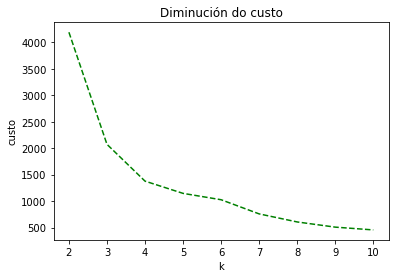

In [69]:
plt.plot(range(2, k_max+1), custos_finais, '--', color="green")
plt.title("Diminución do custo") 
plt.xlabel("k")
plt.ylabel("custo")
plt.show()

A simple vista pódese apreciar que o "cóbado" da función está en $k=4$. A partir deste valor a mellora que obtemos é moito menos significativa. Por tanto podemos asumir que o número de clusters ideal é 4:

In [70]:
k_mellor = 4

# Centroides para o mellor k (4)
centroides_mellor = centroides_finais[k_mellor-2]  # Hai que ter en conta que a lista comeza en 2
centroides_mellor

array([[128.75      , 145.0095    ],
       [ 94.65714286,  88.31571429],
       [155.75      , 272.275     ],
       [258.83333333, 435.845     ]])

In [71]:
# Asignación do mellor cluster para cada un dos 6 primeiros exemplos do dataset
clusters_mellor = clusters_finais[k_mellor-2]  # Hai que ter en conta que a lista comeza en 2
clusters_mellor[:6]

array([0, 2, 2, 0, 2, 1])

Graficamos o último agrupamento, que imos considerar o definitivo:

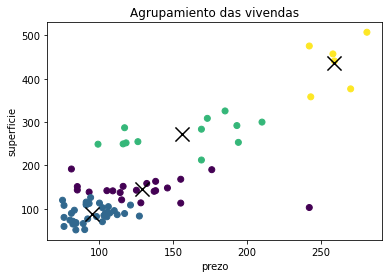

In [72]:
fig = plt.figure()  # Creamos unha figura (contenedor para elementos a debuxar)
ax1 = fig.add_subplot(111, projection='rectilinear')  # Engadimos Axes á figura (contén os elementos do debuxo)

# Engadimos os scatterplots
ax1.scatter(vivendas['superficie'], vivendas['prezo'], c=clusters_mellor)  #Vivendas
ax1.scatter(centroides_mellor[:, 0], centroides_mellor[:, 1], s=200, marker='x', color='black')  # Centroides

ax1.set_title("Agrupamiento das vivendas")  # Poñemos un título
ax1.set_xlabel("prezo")  # Nombramos os eixos
ax1.set_ylabel("superficie")

plt.show()  # Mostramos a figura por pantalla

### Interpretación dos resultados

Quedaría agora unha última etapa de análise e interpretación dos resultados. Haberá situacións (coma esta) onde a interpretación sexa bastante trivial. Sen embargo, en moitos problemas reais onde se traballa cun maior número de variables (porén, xa non estamos falando de interpretar un simple gráfico 2D) pode resultar moi complexo lograr atribuírlle un significado aos grupos formados.

> ❓ **_Pregunta 7._**  Fai unha breve interpretación dos clusters obtidos.

**RESPUESTAS**

Finalmente obtenemos 4 clusters o categorías dentro de nuestro dataset de las viviendas. El primer cluster sería el de las viviendas pequeñas, el segundo serían las viviendas de tamaño mediano, el tercero el de las viviendas grandes y el cuarto el de las viviendas gigantes.

El precio al subir de categoría tiende a aumentar pero no lo añadimos a los clusters ya que hay viviendas de menos categoría mucho más baratos que otros de una mayor.


## Agrupamento coa función `KMeans`

Unha vez máis, `scikit-learn` facilítanos as tarefas de clustering proporcionándonos paquetes e funcións moi útiles. Unha das funcións imprescindibles é `KMeans`. No seguinte script imos volver a obter o primeiro dos agrupamentos que realizamos no exercicio anterior, pero invocando a `KMeans` en lugar de `k_medias`:

In [73]:
from sklearn.cluster import KMeans

# Definimos o número de iteracións
n_iter <- 20

# Obtemos os mesmos centroides iniciais que antes
SEED_VALUE = 190463  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados
np.random.seed(SEED_VALUE)
centr_iniciais = vivendas_mat[np.random.choice(vivendas_mat.shape[0], size=3, replace=False)]

# Definimos o modelo
model = KMeans(n_clusters=len(centr_iniciais), init=centr_iniciais, n_init=1,
               max_iter=n_iter, algorithm='full', random_state=SEED_VALUE)

# Axustamos o modelo aos datos
np.random.seed(SEED_VALUE)
agrupamento_4 = model.fit(vivendas)

O argumento `algorithm="full"` simplemente nos asegura que por debaixo estamos empregando o mesmo método que o que implementamos no exercicio anterior (hai varias implementacións, podes consultalas na axuda de `scikit-learn`). Vemos que os centroides que obtemos con `KMeans` son os mesmos que obtiñamos antes coa nosa implementación propia:

In [74]:
# Centroides da implementación propia
agrupamento_1['centroides'][-1]

array([[258.83333333, 435.845     ],
       [157.30769231, 265.95846154],
       [105.77777778, 107.42740741]])

In [75]:
# Centroides obtidos coa función KMeans
agrupamento_4.cluster_centers_

array([[258.83333333, 435.845     ],
       [157.30769231, 265.95846154],
       [105.77777778, 107.42740741]])

Bótalle un ollo aos atributos que contén a clase `KMeans`. Observa que entre todos os datos de saída non se inclúe directamente o custo da función $J$ coa que estivemos traballando. Inclúese a suma de todas as distancias, sen facer a media:

In [76]:
# Custo final coa implementación propia
agrupamento_1['custo'][-1]

2072.6093651192277

In [77]:
# Custo final coa función KMeans
agrupamento_4.inertia_ / len(vivendas)

2072.6093651192286

Tamén podemos facer o cálculo manualmente, usando a función $J$ que temos definida:

In [78]:
j(x=vivendas_mat, centroides=agrupamento_4.cluster_centers_, clusters=agrupamento_4.labels_)

2072.6093651192286

**************************************************************

# Respostas ao cuestionario (4 puntos)

**LEMBRA:** Non esquezas de escribir teu nome e apelidos na segunda celda do presente documento.

**Pregunta 1**

Se calcula la suma de distancias de cada punto cons sus centros, cuando mejor fijados estén los centros, menor será la suma de sus distancias.

**Pregunta 2**

Devuelve una matriz con las distancias cuadráticas entre los puntos y los centroides que existen

**Pregunta 3**

x_cluster_i lo que hace es almacenar todos los puntos que pertenecena l cluster i.

El np.sum lo que hace es la media de los puntos que pertenecen a cada centroide para poder definir el nuevo centroide.

**Pregunta 4**

La primera etapa se hace fuera de kmean al darle ya los centroides elegidos, liego la funcion ya no los elige al azar y los va eligiendo según su coste.

La segunda etapa es la de asignar los puntos a sus centros, esta se ejecuta tanto en calcula_distancias como en la siguiente línea de kmeans. En la primera se llama a la funcion calcula distancias que devuelve un matriz con todas las distancias entre los puntos y los centros que existen. En la siguiente se encuentra el punto mas próximo, es decir, el centroide que está a una distancia menor de cada punto.

La última etapa es la de actualizar los centros y la realiza con la funcion actualizar centr, en ella coge el punto medio de los puntos de cada grupo y lo ace un nuevo centro.

**Pregunta 5**

    1.custo_minimo: almacenamos en custos_finais, como el propio nombre indica, el coste final de cada solucion dada para cada grupo de centroides iniciales. De todos estos obtenemos el minimo y es lo que devuelve, el coste mínimo obtenido comparando cada ejecucion de k_means.
    
    2.mellor_iteracion: obtenemos el índice de la mejor iteración del k_means; es decir, el grupo de centroides que obtuvo el mejor resultado. Por mejor resultado se entiende que el que haya obtenido un menor coste final. A partir de este índice accedemos a los próximos return de la función.
    
    3.centroides_mellor: que es el propio grupo de centroides que obtuvo el mejor resultado.
    
    4.mellor_asignacion: es el resultado de la asignación a cada punto del dataset dentro de los centroides creados. Nos dice cada punto, a que centroide pertenece.

**Pregunta 6**

El metodo se ejecuta 90 veces. Lo sabemos al ponerle un print cada vez que se ejecute y contarlos.

**Pregunta 7**

Finalmente obtenemos 4 clusters o categorías dentro de nuestro dataset de las viviendas. El primer cluster sería el de las viviendas pequeñas, el segundo serían las viviendas de tamaño mediano, el tercero el de las viviendas grandes y el cuarto el de las viviendas gigantes.

El precio al subir de categoría tiende a aumentar pero no lo añadimos a los clusters ya que hay viviendas de menos categoría mucho más baratos que otros de una mayor.

**************************************************************

# Modelado dun problema de libre elección 

## Enunciado

Pon en práctica os teus coñecementos de aprendizaxe non supervisado e intenta agora ti buscar relacións entre os datos dun problema que se che ocorra. Nos exercicios anteriores abordouse o caso de 2 variables, polo que animámoste agora a que trates de aplicar clustering sobre un problema con máis dimensións. O único requerimento obrigatorio é **empregar máis de dúas variables para o clustering**. Ten en conta que a nosa implementación de k-means (`k_medias`) está pensada para funcionar sobre conxuntos de datos con dúas variables, pero non é escalable a máis dimensións (certo é que as modificacións necesarias para logralo son mínimas). A vantaxe da función `KMeans` propia de `scikit-learn` é a súa flexibilidade, pois o seu parámetro `x` pode tomar como entrada conxuntos de datos cun maior número de variables. Ten tamén presente que ao aplicar clustering sobre un conxunto de datos de máis de 2 ou 3 variables, a súa visualización complícase e o mellor é visualizar o agrupamento por pares de variables de cara a obter unha boa interpretación.

Igual que na práctica anterior, podes recadar datos e construir un pequeno dataset ti mesmo ou ben obter un de Internet. Fai un breve estudo dos teus datos, incluíndo gráficas e comentarios propios. Obtén un bo agrupamento e da unha interpretación do mesmo. Proporciona todo o código que consideres necesario empregando scripts como os dos exercicios anteriores. Ao entregar esta práctica deberás incluir tamén o arquivo cos datos do teu problema no formato que che resulte máis cómodo (.csv, .txt, etc.).

**************************************************************

## Resposta (6 puntos)

Para la resolución de este ejecricio utilizaremos el mismo dataset que creamos para la práctica anterior. Las variables observadas serán la edad y los goles que hayan anotado a lo largo de su carrera y la que se querrá predecir será el precio del jugador. Se analizarán 50 datos, que fueron recopilados de las paginas transfermarkt y fichajes.com. En la primera columna se almacena la edad, en la segundad los goles anotados a lo largo de toda su carrera y por último el valor de mercado en millones de eurosque estos tienen.

In [4]:
import pandas as pd  # Importamos a librería (isto sólo é necesario facelo unha vez)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans



delanteros = pd.read_csv('delanteros_masValiosos.txt',  # Cargamos o csv
                       delimiter=',',
                       header=0)
delanteros.head()

edad  goles  precio
0    22    158     170
1    23    244     160
2    22     78     120
3    22     69     110
4    21     43      90

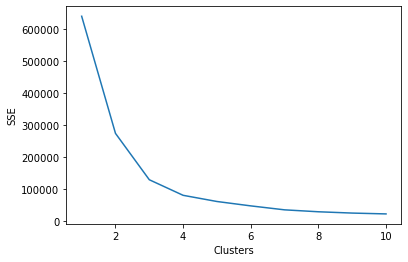

In [6]:
#metodo del codo para definir el numero de clusters
#elbow method
wcss = []
for i in range(1,11):
    k_means = KMeans(n_clusters=i,init='k-means++', random_state=42)
    k_means.fit(delanteros)
    wcss.append(k_means.inertia_)
#plot elbow curve
plt.plot(np.arange(1,11),wcss)
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.show()

In [12]:
k_means_optimum = KMeans(n_clusters = 3, init = 'k-means++',  random_state=42)
y = k_means_optimum.fit_predict(delanteros)
print(y)

[2 2 0 0 0 2 0 0 0 2 0 0 0 0 2 0 0 0 0 2 2 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 0 0 1]


In [19]:
delanteros['cluster'] = y

In [18]:
del1 = delanteros.Cluster

In [24]:
delanteros1 = delanteros[delanteros.cluster==0]
delanteros2 = delanteros[delanteros.cluster==1]
delanteros3 = delanteros[delanteros.cluster==2]
delanteros.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   edad     50 non-null     int64
 1   goles    50 non-null     int64
 2   precio   50 non-null     int64
 3   Cluster  50 non-null     int32
 4   cluster  50 non-null     int32
dtypes: int32(2), int64(3)
memory usage: 1.7 KB


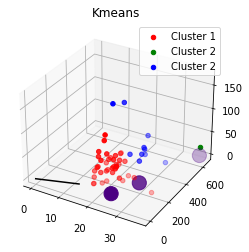

In [25]:
kplot = plt.axes(projection='3d')
xline = np.linspace(0, 15, 1000)
yline = np.linspace(0, 15, 1000)
zline = np.linspace(0, 15, 1000)
kplot.plot3D(xline, yline, zline, 'black')
# Data for three-dimensional scattered points
kplot.scatter3D(delanteros1.edad, delanteros1.goles, delanteros1.precio, c='red', label = 'Cluster 1')
kplot.scatter3D(delanteros2.edad,delanteros2.goles,delanteros2.precio,c ='green', label = 'Cluster 2')
kplot.scatter3D(delanteros3.edad,delanteros3.goles,delanteros3.precio,c ='blue', label = 'Cluster 2')
plt.scatter(k_means_optimum.cluster_centers_[:,0], k_means_optimum.cluster_centers_[:,1], color = 'indigo', s = 200)
plt.legend()
plt.title("Kmeans")
plt.show()

In [27]:
from sklearn.metrics import silhouette_score
score = silhouette_score(delanteros,y)
print(score)
#OUTPUT: 0.7256352649604982

0.5969039213996671
